In [1]:
import brian2
import pickle
import scipy.io as sio
from pathlib import Path
import numpy as np

INFO       Cache size for target 'cython': 2252192766 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\bci-admin\.cython\brian_extensions' directory. [brian2]


In [2]:
from brian2 import *

In [3]:
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import metrics

In [4]:
%matplotlib inline

In [5]:
10*nA*5*Mohm

50. * mvolt

In [6]:
import scipy.io as sio
from pathlib import Path
import numpy as np


mask = np.array([np.ones(32), np.ones(32), np.ones(32),np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3)))]).astype(np.bool)
mask = mask.reshape((1024,))

WARNING    C:\Users\bci-admin\AppData\Local\Temp\ipykernel_12820\3725482898.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.concatenate((np.zeros(25), np.ones(4), np.zeros(3)))]).astype(np.bool)
 [py.warnings]


In [7]:
def normalize(pressure):
    """
    Scales each array of the given array of arrays to the range [0, 1]
    Only considers values in the same tactile frame
    """
    normalized_p = np.copy(pressure)
    for i, press in enumerate(pressure):
        min_p = np.min(press)
        normalized_p[i] = (press - min_p) / np.max(press - min_p)
    
    return normalized_p
 

def boost(pressure): 
    """
    The higher a value is from the mean of the frame, the more it gets boosted.
    The idea is that tactile features are robuster
    """
    for press in pressure:
        mean_p = np.mean(press[mask])
        boost_mask = press > mean_p
        press[boost_mask] = list(map(lambda x: 4*(x-mean_p), press[boost_mask]))
        
    return pressure

In [8]:
filename = Path('C:/Users/bci-admin/Downloads/smarthand_dataset.mat')

data = sio.loadmat(filename, squeeze_me=True)
valid_mask = data['valid_flag'] == 1
pressure = data['tactile_data'][valid_mask]
# Scale data to the range [0, 1]
pressure = np.clip((pressure.astype(np.float32)-1500)/(2700-1500), 0.0, 1.0)
#pressure = normalize(pressure.astype(np.float32))
#pressure = np.exp2(pressure)
#pressure = np.clip((pressure-1), 0.0, 1.0)
#pressure = boost(pressure)
pressure = np.clip(pressure, 0.0, 1.0)

pressure[:, ~mask] = 0.0
object_id = data['object_id'][valid_mask]


In [9]:
print(pressure.shape)

(195072, 1024)


In [33]:
# Spike conversion using bADM
def bADM_rsig(input_signal,threshold_UP,threshold_DOWN,sampling_frequency,refractory_period_duration,return_signal = True):
    dt = 1/sampling_frequency
    end_time = len(input_signal)*dt
    times = np.linspace(0,end_time,len(input_signal)).astype(np.float64)
    DC_Voltage = input_signal[0]
    remainder_of_refractory = 0
    spike_t_up =  times[0:2]
    spike_t_dn = times[0:2]
    interpolate_from = 0.0
    interpolation_activation = 0
    intercept_point=0
    
    for i in range(len(times)):
        t = i * dt
        if i == 0:
            continue
        
        slope = ((input_signal[i]-input_signal[i-1])/dt)
        if remainder_of_refractory >= 2*dt:
            remainder_of_refractory = remainder_of_refractory-dt
            interpolation_activation = 1

        else:
            
            if interpolation_activation == 1:
                interpolate_from = (interpolate_from+remainder_of_refractory)
                remainder_of_refractory = 0
                if interpolate_from >= 2*dt:
                    interpolate_from = interpolate_from-dt
                    continue
                interpolate_from = (interpolate_from+remainder_of_refractory)%dt
                Vbelow = (input_signal[i-1] + interpolate_from*slope)
                DC_Voltage = Vbelow
            
                
            else:
                Vbelow = input_signal[i-1]
                interpolate_from = 0

            if DC_Voltage + threshold_UP <= input_signal[i]:
                intercept_point = t - dt + interpolate_from+((threshold_UP+DC_Voltage-Vbelow)/slope)
                spike_t_up = np.append(spike_t_up,intercept_point)
                interpolate_from = dt+intercept_point-t
                remainder_of_refractory = refractory_period_duration 
                interpolation_activation = 1
                continue

            elif DC_Voltage - threshold_DOWN >= input_signal[i]:
                intercept_point = t - dt + interpolate_from+((-threshold_DOWN+DC_Voltage-Vbelow)/slope)
                spike_t_dn = np.append(spike_t_dn,intercept_point)
                interpolate_from = dt+intercept_point-t
                remainder_of_refractory = refractory_period_duration 
                interpolation_activation = 1
                continue

            interpolation_activation = 0
                        
    index =[0,1]
    spike_t_up = np.delete(spike_t_up, index)
    spike_t_dn = np.delete(spike_t_dn, index)


    if return_signal:
        sup = np.zeros_like(times);sdw = np.zeros_like(times)
        sup[np.searchsorted(times,spike_t_up,side='left')] = 1
        sdw[np.searchsorted(times,spike_t_dn,side='left')] = 1
        rsig=(threshold_UP * np.cumsum(sup)) + ((-threshold_DOWN) * np.cumsum(sdw)) + input_signal[0]
        # rsig_up=(threshold_UP * np.cumsum(sup)) + input_signal[0]

    return spike_t_up,spike_t_dn,rsig #,rsig_up


### Results of thresholds within range: np.linspace(0.05, 0.3, num=6)

In [ ]:
import time

delta_range = np.linspace(0.05, 0.3, num=6)
ref = 0
sampling_freq = 100
N = 1024
T = 3400 # seconds

N_frames = 4

object_id = data['object_id']

acc_list = []

for delta in delta_range:
    
    time_start = time.time()
    
    print("\nThreshold delta: {}".format(delta))
    rsig_full = []
    upFR_avg = 0
    dwFR_avg = 0
    
    for i in range(len(pressure[0])):
        sig = pressure.T[i]
        tup,tdw,rsig = bADM_rsig(sig,delta,delta,sampling_freq,ref)

        rsig_full.append(rsig)
        
        upFR_avg += len(tup)/T
        dwFR_avg += len(tdw)/T

        if i % 50 == 0:
            print("    Processed channels: {}".format(i))
            
    with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/signal_reconstruction/rsig_full", "wb") as fp: 
        pickle.dump(rsig_full, fp)
        print("File saved!!")
            
    rsig_full_arr = np.asarray(rsig_full)
    
    print(rsig_full_arr)
    
    upFR_avg /= N
    dwFR_avg /= N
    
    print("    Avg. firing rate of 1024 channels, up: {}, down: {} spikes per second".format(upFR_avg, dwFR_avg))
    
    sample = []
    reconstruct_full = rsig_full_arr.T
    for i in range(int(reconstruct_full.shape[0]/N_frames)):
        sample.append(reconstruct_full[N_frames*i:N_frames*i+N_frames,:])

    sample = np.array(sample)
    print(sample.shape)
    sample = sample.reshape((-1, 32*32*N_frames))
    object_sample = object_id[0:-N_frames:N_frames]
    print(object_sample.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(np.array(sample), np.array(object_sample), test_size=0.2, random_state=42)
    print(X_train.shape)
    print(y_train.shape)
    
    clf = svm.SVC(kernel='linear') 

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    print("Accuracy:", acc)
    
    time_end = time.time()
    
    print("Time elapsed {} for current delta = {}".format(time_end-time_start, delta))

In [ ]:
acc_arr = np.array(acc_list)

In [ ]:
acc_arr

### Results of thresholds within range: np.linspace(0.1, 0.3, num=5)

In [12]:
import time

delta_range = np.linspace(0.1, 0.3, num=5)
ref = 0
sampling_freq = 100
N = 1024
T = 3400 # seconds

N_frames = 4

object_id = data['object_id']

acc_list = []

for delta in delta_range:
    
    time_start = time.time()
    print("\nThreshold delta: {}".format(delta))
    rsig_full = []
    upFR_avg = 0
    dwFR_avg = 0
    
    for i in range(len(pressure[0])):
        sig = pressure.T[i]
        tup,tdw,rsig = bADM_rsig(sig,delta,delta,sampling_freq,ref)

        rsig_full.append(rsig)
        
        upFR_avg += len(tup)/T
        dwFR_avg += len(tdw)/T

        if i % 50 == 0:
            print("    Processed channels: {}".format(i))
            
    with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/signal_reconstruction/rsig_full", "wb") as fp: 
        pickle.dump(rsig_full, fp)
        print("File saved!!")
            
    rsig_full_arr = np.asarray(rsig_full)
    
    print(rsig_full_arr)
    
    upFR_avg /= N
    dwFR_avg /= N
    
    print("    Avg. firing rate of 1024 channels, up: {}, down: {} spikes per second".format(upFR_avg, dwFR_avg))
    
    sample = []
    reconstruct_full = rsig_full_arr.T
    for i in range(int(reconstruct_full.shape[0]/N_frames)):
        sample.append(reconstruct_full[N_frames*i:N_frames*i+N_frames,:])

    sample = np.array(sample)
    print(sample.shape)
    sample = sample.reshape((-1, 32*32*N_frames))
    object_sample = object_id[0:-N_frames:N_frames]
    print(object_sample.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(np.array(sample), np.array(object_sample), test_size=0.2, random_state=42)
    print(X_train.shape)
    print(y_train.shape)
    
    clf = svm.SVC(kernel='linear') 

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    print("Accuracy:", acc)
    
    
    time_end = time.time()
    
    print("Time elapsed {} for current delta = {}".format(time_end-time_start, delta))


Threshold delta: 0.1
    Processed channels: 0
    Processed channels: 50
    Processed channels: 100
    Processed channels: 150
    Processed channels: 200
    Processed channels: 250
    Processed channels: 300
    Processed channels: 350
    Processed channels: 400
    Processed channels: 450
    Processed channels: 500
    Processed channels: 550
    Processed channels: 600
    Processed channels: 650
    Processed channels: 700
    Processed channels: 750
    Processed channels: 800
    Processed channels: 850
    Processed channels: 900
    Processed channels: 950
    Processed channels: 1000
File saved!!
[[0.1225     0.1225     0.1225     ... 0.2225     0.2225     0.2225    ]
 [0.03083333 0.03083333 0.03083333 ... 0.03083333 0.03083333 0.03083333]
 [0.0575     0.0575     0.0575     ... 0.1575     0.1575     0.1575    ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.     

### Results of thresholds within range: np.linspace(0.005, 0.03, num=6)

In [13]:
import time

delta_range = np.linspace(0.005, 0.03, num=6)
ref = 0
sampling_freq = 100
N = 1024
T = 3400 # seconds

N_frames = 4

object_id = data['object_id']

acc_list = []

for delta in delta_range:
    
    time_start = time.time()
    print("\nThreshold delta: {}".format(delta))
    rsig_full = []
    upFR_avg = 0
    dwFR_avg = 0
    
    for i in range(len(pressure[0])):
        sig = pressure.T[i]
        tup,tdw,rsig = bADM_rsig(sig,delta,delta,sampling_freq,ref)

        rsig_full.append(rsig)
        
        upFR_avg += len(tup)/T
        dwFR_avg += len(tdw)/T

        if i % 50 == 0:
            print("    Processed channels: {}".format(i))
            
    with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/signal_reconstruction/rsig_full", "wb") as fp: 
        pickle.dump(rsig_full, fp)
        print("File saved!!")
            
    rsig_full_arr = np.asarray(rsig_full)
    
    print(rsig_full_arr)
    
    upFR_avg /= N
    dwFR_avg /= N
    
    print("    Avg. firing rate of 1024 channels, up: {}, down: {} spikes per second".format(upFR_avg, dwFR_avg))
    
    sample = []
    reconstruct_full = rsig_full_arr.T
    for i in range(int(reconstruct_full.shape[0]/N_frames)):
        sample.append(reconstruct_full[N_frames*i:N_frames*i+N_frames,:])

    sample = np.array(sample)
    print(sample.shape)
    sample = sample.reshape((-1, 32*32*N_frames))
    object_sample = object_id[0:-N_frames:N_frames]
    print(object_sample.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(np.array(sample), np.array(object_sample), test_size=0.2, random_state=42)
    print(X_train.shape)
    print(y_train.shape)
    
    clf = svm.SVC(kernel='linear') 

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    print("Accuracy:", acc)
    
    
    time_end = time.time()
    
    print("Time elapsed {} for current delta = {}".format(time_end-time_start, delta))


Threshold delta: 0.005
    Processed channels: 0
    Processed channels: 50
    Processed channels: 100
    Processed channels: 150
    Processed channels: 200
    Processed channels: 250
    Processed channels: 300
    Processed channels: 350
    Processed channels: 400
    Processed channels: 450
    Processed channels: 500
    Processed channels: 550
    Processed channels: 600
    Processed channels: 650
    Processed channels: 700
    Processed channels: 750
    Processed channels: 800
    Processed channels: 850
    Processed channels: 900
    Processed channels: 950
    Processed channels: 1000
File saved!!
[[ 0.1225      0.1225      0.1225     ... 16.6175     16.6175
  16.6175    ]
 [ 0.03083333  0.03083333  0.03083333 ... 15.49083333 15.48583333
  15.48583333]
 [ 0.0575      0.0575      0.0575     ... 14.0275     14.0275
  14.0275    ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0. 

(84997, 4, 1024)
(84997,)
(67997, 4096)
(67997,)
Accuracy: 0.9984117647058823
Time elapsed 2173.3398871421814 for current delta = 0.03


### Plots of threshold vs. accuracy / firing rates

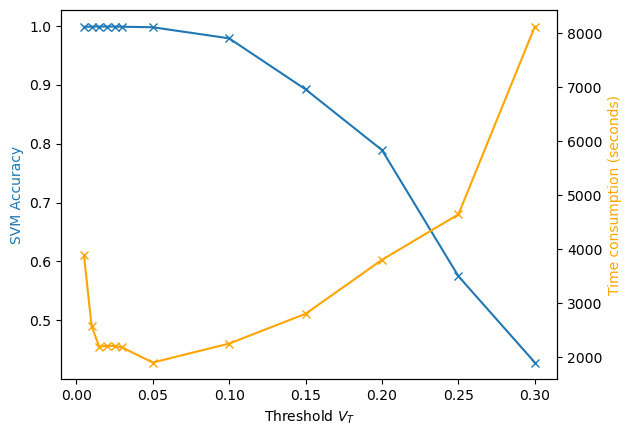

In [1]:
import matplotlib.pyplot as plt
import numpy as np

ax1 = plt.subplot()

threshold_delta = np.array([0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
Accuracy = np.array([0.998294, 0.998588, 0.998706, 0.998765, 0.998706, 0.998412, 0.997529, 0.978706, 0.892118, 0.789059, 0.575, 0.428529])
Time = np.array([3883.90, 2570.68, 2184.92, 2204.34, 2200.78, 2173.34, 1894.27, 2245.62, 2796.64, 3796.28, 4638.49, 8117.09])

plt.plot(threshold_delta, Accuracy, marker='x', label='SVM Accuracy')

plt.xlabel('Threshold $V_T$')
plt.ylabel('SVM Accuracy', color='tab:blue')


ax2 = ax1.twinx()
ax2.plot(threshold_delta, Time, marker='x', color='orange')
plt.ylabel('Time consumption (seconds)', color='orange')

plt.show()

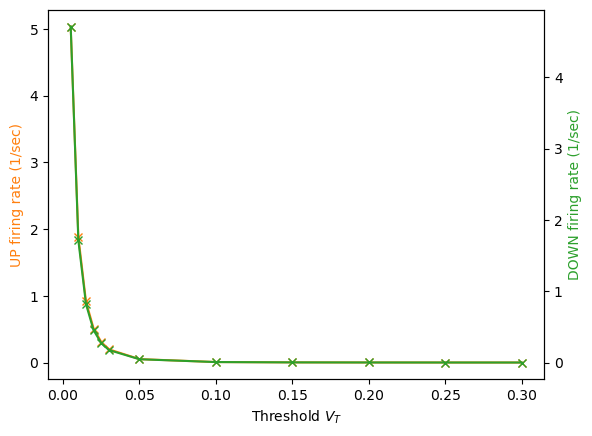

In [2]:
import matplotlib.pyplot as plt
import numpy as np

ax1 = plt.subplot()

threshold_delta = np.array([0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
UP_rate = np.array([5.033286132812504, 1.8848914292279422, 0.9146561925551465, 0.5086006433823533, 0.30799603630514727, 0.19802590762867645, 0.0513209443933823, 0.007391429227941186, 0.002399471507352939, 0.001112132352941176, 0.0006051815257352939, 0.00032858455882352975])
DOWN_rate = np.array([4.71075568704044, 1.712119715073529, 0.8191549862132358, 0.45175723805147106, 0.27259334788602935, 0.1753176700367646, 0.046185661764705836, 0.006819565716911764, 0.0022222541360294094, 0.0010354434742647046, 0.000567267922794118, 0.000308478860294118])

plt.plot(threshold_delta, UP_rate, marker='x', color='tab:orange', label='SVM Accuracy')

plt.xlabel('Threshold $V_T$')
plt.ylabel('UP firing rate (1/sec)', color='tab:orange')


ax2 = ax1.twinx()
ax2.plot(threshold_delta, DOWN_rate, marker='x', color='tab:green')
plt.ylabel('DOWN firing rate (1/sec)', color='tab:green')

plt.show()

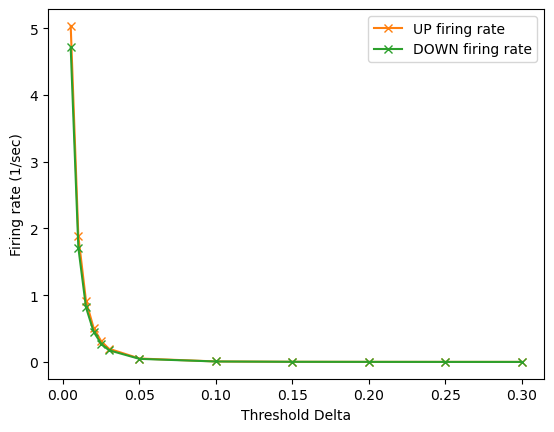

In [9]:
import matplotlib.pyplot as plt
import numpy as np


threshold_delta = np.array([0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
UP_rate = np.array([5.033286132812504, 1.8848914292279422, 0.9146561925551465, 0.5086006433823533, 0.30799603630514727, 0.19802590762867645, 0.0513209443933823, 0.007391429227941186, 0.002399471507352939, 0.001112132352941176, 0.0006051815257352939, 0.00032858455882352975])
DOWN_rate = np.array([4.71075568704044, 1.712119715073529, 0.8191549862132358, 0.45175723805147106, 0.27259334788602935, 0.1753176700367646, 0.046185661764705836, 0.006819565716911764, 0.0022222541360294094, 0.0010354434742647046, 0.000567267922794118, 0.000308478860294118])

plt.plot(threshold_delta, UP_rate, marker='x', color='tab:orange', label='UP firing rate')
plt.plot(threshold_delta, DOWN_rate, marker='x', color='tab:green', label='DOWN firing rate')

plt.xlabel('Threshold Delta')
plt.ylabel('Firing rate (1/sec)')

plt.legend()

plt.show()

### Different window (chunk) size for RMSE

In [16]:
from sklearn.metrics import mean_squared_error

window_idx_range = np.linspace(100, 1000, num=10)
rmse_full_list = []

delta = 0.1
rsig_full = []

for i in range(len(pressure[0])):
    sig = pressure.T[i]
    tup,tdw,rsig = bADM_rsig(sig,delta,delta,sampling_freq,ref)

    rsig_full.append(rsig)

    if i % 50 == 0:
        print("Delta = 0.1, Processed channels: {}".format(i))
        
with open("C:/Users/bci-admin/Downloads/glove_snn_save/data/signal_reconstruction/rsig_full", "wb") as fp: 
    pickle.dump(rsig_full, fp)
    print("File saved!!")

rsig_full_arr = np.asarray(rsig_full)

for window_idx in window_idx_range:
    rm_list = []
    print("Chunk size: {}".format(window_idx))
    
    for i in range(rsig_full_arr.shape[0]):
        rm = 0
        count = 0
        for id in range(0,len(rsig_full[i]),int(window_idx)): #iterating over the chunks of length window
            if (id+window_idx)>=len(rsig_full[i]): #For the Last chunk whose length may be smaller than others
                chunk1=pressure.T[i,id:len(rsig_full[i])];
                chunk3=rsig_full_arr[i,id:len(rsig_full[i])]
                rm+=mean_squared_error((chunk1 - np.mean(chunk1)), (chunk3 - np.mean(chunk3)), squared=False)
                break
            chunk1=pressure.T[i,id:id+window_idx];chunk3=rsig_full_arr[i,id:id+window_idx];
            rm+=mean_squared_error((chunk1 - np.mean(chunk1)), (chunk3 - np.mean(chunk3)), squared=False)
            count+=1
        rm_list.append(rm/(count+1))

        if i % 50 == 0:
            print("Processed channels: {}".format(i))
            
    rmse_cur = np.asarray(rm_list).sum()/len(rm_list)
    rmse_full_list.append(rmse_cur)

Delta = 0.1, Processed channels: 0
Delta = 0.1, Processed channels: 50
Delta = 0.1, Processed channels: 100
Delta = 0.1, Processed channels: 150
Delta = 0.1, Processed channels: 200
Delta = 0.1, Processed channels: 250
Delta = 0.1, Processed channels: 300
Delta = 0.1, Processed channels: 350
Delta = 0.1, Processed channels: 400
Delta = 0.1, Processed channels: 450
Delta = 0.1, Processed channels: 500
Delta = 0.1, Processed channels: 550
Delta = 0.1, Processed channels: 600
Delta = 0.1, Processed channels: 650
Delta = 0.1, Processed channels: 700
Delta = 0.1, Processed channels: 750
Delta = 0.1, Processed channels: 800
Delta = 0.1, Processed channels: 850
Delta = 0.1, Processed channels: 900
Delta = 0.1, Processed channels: 950
Delta = 0.1, Processed channels: 1000
File saved!!
Chunk size: 100.0


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [22]:
for window_idx in window_idx_range:
    rm_list = []
    print("Chunk size: {}".format(window_idx))
    
    for i in range(rsig_full_arr.shape[0]):
        rm = 0
        count = 0
        window_len = int(window_idx)
        for id in range(0,len(rsig_full[i]),window_len): #iterating over the chunks of length window
            if (id+window_len)>=len(rsig_full[i]): #For the Last chunk whose length may be smaller than others
                chunk1=pressure.T[i,id:len(rsig_full[i])];
                chunk3=rsig_full_arr[i,id:len(rsig_full[i])]
                rm+=mean_squared_error((chunk1 - np.mean(chunk1)), (chunk3 - np.mean(chunk3)), squared=False)
                break
            chunk1=pressure.T[i,id:id+window_len];chunk3=rsig_full_arr[i,id:id+window_len];
            rm+=mean_squared_error((chunk1 - np.mean(chunk1)), (chunk3 - np.mean(chunk3)), squared=False)
            count+=1
        rm_list.append(rm/(count+1))

        if i % 50 == 0:
            print("Processed channels: {}".format(i))
            
    rmse_cur = np.asarray(rm_list).sum()/len(rm_list)
    rmse_full_list.append(rmse_cur)

Chunk size: 100.0
Processed channels: 0
Processed channels: 50
Processed channels: 100
Processed channels: 150
Processed channels: 200
Processed channels: 250
Processed channels: 300
Processed channels: 350
Processed channels: 400
Processed channels: 450
Processed channels: 500
Processed channels: 550
Processed channels: 600
Processed channels: 650
Processed channels: 700
Processed channels: 750
Processed channels: 800
Processed channels: 850
Processed channels: 900
Processed channels: 950
Processed channels: 1000
Chunk size: 200.0
Processed channels: 0
Processed channels: 50
Processed channels: 100
Processed channels: 150
Processed channels: 200
Processed channels: 250
Processed channels: 300
Processed channels: 350
Processed channels: 400
Processed channels: 450
Processed channels: 500
Processed channels: 550
Processed channels: 600
Processed channels: 650
Processed channels: 700
Processed channels: 750
Processed channels: 800
Processed channels: 850
Processed channels: 900
Processed

In [23]:
rmse_full_list

[0.0042632808298122965,
 0.0050013712419321454,
 0.005465930485278345,
 0.0057082678710827246,
 0.005985187249861001,
 0.00627584755258412,
 0.00646486305591539,
 0.0065026365532383805,
 0.006771166206541472,
 0.00677036859634864]

In [24]:
rmse_cur

0.00677036859634864

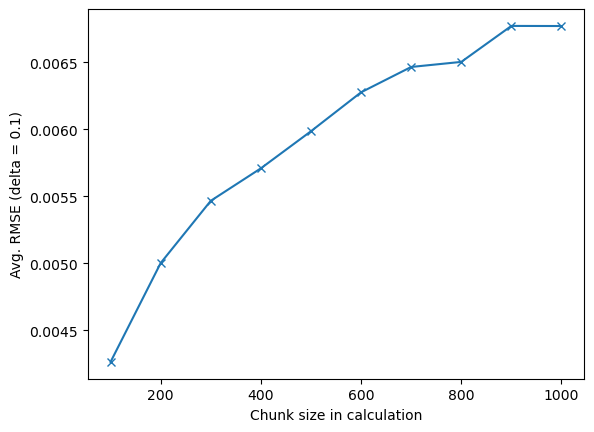

In [51]:
import matplotlib.pyplot as plt
import numpy as np

ax1 = plt.subplot()

chunk_size = np.linspace(100, 1000, num=10)
RMSE = np.array([0.0042632808298122965,
 0.0050013712419321454,
 0.005465930485278345,
 0.0057082678710827246,
 0.005985187249861001,
 0.00627584755258412,
 0.00646486305591539,
 0.0065026365532383805,
 0.006771166206541472,
 0.00677036859634864])

plt.plot(chunk_size, RMSE, marker='x', label='SVM Accuracy')

plt.xlabel('Chunk size in calculation')
plt.ylabel('Avg. RMSE (delta = 0.1)')

plt.show()